## H2 Molecule VQE with Qiskit (Primitives V2)

This notebook implements the Variational Quantum Eigensolver (VQE) for the Hydrogen molecule ($H_2$) 

This notebook uses **Qiskit Primitives V2** (`StatevectorEstimator`) as the standard `Estimator`


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator


## 1. Define the Hamiltonian
For $H_2$ at bond distance $0.735 \AA$, the Hamiltonian can be reduced to a 1-qubit operator.

$$ \hat{H} = -1.04886 I - 0.79674 Z + 0.18122 X $$

We also add the **Nuclear Repulsion Energy** constant: $0.71997$ Hartree.


In [3]:

# Define the 1-qubit Hamiltonian for H2 at 0.735 Angstrom
hamiltonian = SparsePauliOp.from_list([
    ("I", -1.04886087), 
    ("Z", -0.7967368), 
    ("X", 0.18121804)
])

# Nuclear repulsion energy
nuclear_repulsion = 0.71997

print("Hamiltonian:")
print(hamiltonian)


Hamiltonian:
SparsePauliOp(['I', 'Z', 'X'],
              coeffs=[-1.04886087+0.j, -0.7967368 +0.j,  0.18121804+0.j])


## 2. Construct the Ansatz
We use a 3-parameter ansatz: $R_x(\theta_0) R_z(\theta_1) R_x(\theta_2)$.


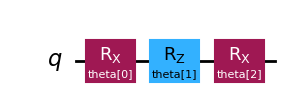

In [4]:

def create_ansatz():
    qc = QuantumCircuit(1)
    theta = ParameterVector('theta', 3)
    qc.rx(theta[0], 0)
    qc.rz(theta[1], 0)
    qc.rx(theta[2], 0)
    return qc

ansatz = create_ansatz()
ansatz.draw('mpl')


## 3. Define the Cost Function (V2 Primitives)
We use the `StatevectorEstimator` which follows the **V2 Primitives** interface.


In [5]:

# Use the Qiskit StatevectorEstimator (exact simulation)
estimator = StatevectorEstimator()

def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, [hamiltonian], [params])
    job = estimator.run([pub])
    result = job.result()
    energy = result[0].data.evs[0]
    return float(energy)


## 4. Run VQE Optimization (with Explainable Logs)
We use `scipy.optimize.minimize` with the **COBYLA** method. 

We added a **Callback Logger** to make the process easier to understand.


In [6]:

# Initial guess
x0 = np.random.random(3) * 2 * np.pi

print("--- Starting VQE Optimization ---")

class VQELogger:
    def __init__(self):
        self.iter_count = 0
        self.energy_history = []
        self.parameter_history = []
        self.start_time = time.time()
        # Print Header
        print(f"{'Iter':^5} | {'Energy (Hartree)':^18} | {'Diff':^12} | {'Params (Theta)':^30}")
        print("-" * 75)

    def callback(self, xk):
        # Calculate current energy
        val = cost_func(xk, ansatz, hamiltonian, estimator)
        total_energy = val + nuclear_repulsion
        
        # Calculate difference from previous
        if self.energy_history:
            diff = total_energy - self.energy_history[-1]
            diff_str = f"{diff:+.2e}"
        else:
            diff_str = "   N/A   "
            
        self.energy_history.append(total_energy)
        self.parameter_history.append(xk.copy())
        self.iter_count += 1
        
        # Format parameters for display
        params_str = f"[{xk[0]:.2f}, {xk[1]:.2f}, {xk[2]:.2f}]"
        
        # Print Log Line
        print(f"{self.iter_count:5d} | {total_energy:18.6f} | {diff_str:>12} | {params_str}")

# Initialize Logger
logger = VQELogger()

# Run Optimization
res = minimize(
    cost_func, 
    x0, 
    args=(ansatz, hamiltonian, estimator), 
    method="COBYLA", 
    options={"maxiter": 100},
    callback=logger.callback
)

optimized_energy = res.fun + nuclear_repulsion
energy_history = logger.energy_history # Save for plotting
parameter_history = np.array(logger.parameter_history)

print("-" * 75)
print("\nOptimization Complete!")
print(f"Optimal Parameters: {res.x}")
print(f"VQE Ground State Energy: {optimized_energy:.6f} Hartree")


--- Starting VQE Optimization ---
Iter  |  Energy (Hartree)  |     Diff     |         Params (Theta)        
---------------------------------------------------------------------------
    1 |          -0.501366 |       N/A    | [1.19, 4.59, 5.03]
    2 |          -0.706856 |    -2.05e-01 | [0.19, 5.59, 5.03]
    3 |          -1.137523 |    -4.31e-01 | [0.19, 5.59, 6.03]
    4 |          -0.942449 |    +1.95e-01 | [-0.00, 5.84, 6.98]
    5 |          -1.098076 |    -1.56e-01 | [0.09, 5.72, 6.50]
    6 |          -1.072731 |    +2.53e-02 | [-0.04, 5.65, 5.97]
    7 |          -1.137236 |    -6.45e-02 | [0.48, 5.98, 5.94]
    8 |          -1.112600 |    +2.46e-02 | [0.60, 5.29, 6.05]
    9 |          -1.067415 |    +4.52e-02 | [0.08, 5.62, 5.81]
   10 |          -1.145644 |    -7.82e-02 | [0.29, 5.52, 6.05]
   11 |          -1.140156 |    +5.49e-03 | [0.31, 5.53, 6.17]
   12 |          -1.144653 |    -4.50e-03 | [0.26, 5.47, 6.06]
   13 |          -1.144373 |    +2.80e-04 | [0.38, 5.46, 

## 5. Visualization of Convergence


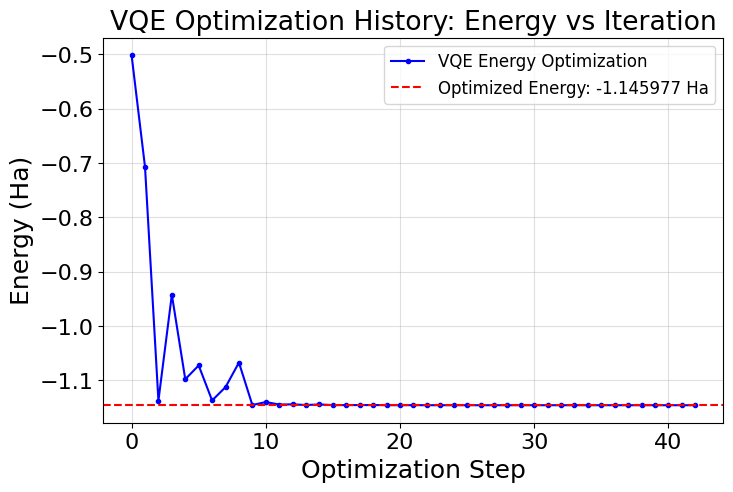

In [17]:

# Plot Convergence
plt.figure(figsize=(8, 5))
plt.plot(energy_history, 'b.-', label='VQE Energy Optimization')
plt.axhline(y=optimized_energy, color='r', linestyle='--', label=f"Optimized Energy: {optimized_energy:.6f} Ha")

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.xlabel('Optimization Step')
plt.ylabel('Energy (Ha)')
plt.title('VQE Optimization History: Energy vs Iteration')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4)
# plt.savefig('VQE-Optimization-History.pdf', bbox_inches='tight')
plt.show()


## 6. Energy Landscape Analysis (All Parameters)

To verify the stability of our solution, we perform a 1D scan for **each of the 3 parameters**.
This produces 3 plots, showing the energy valley for $\theta_0$, $\theta_1$, and $\theta_2$.


--- Scanning Energy Landscape for Theta 0 ---


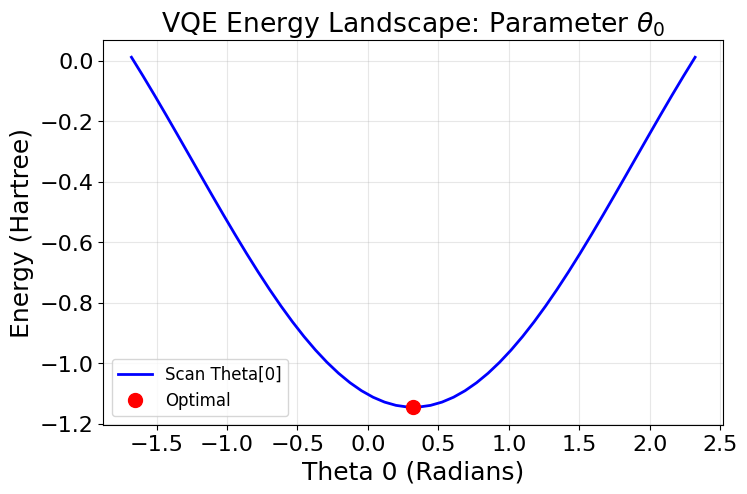

In [16]:

print("\n--- Scanning Energy Landscape for Theta 0 ---")

best_params = res.x
scan_points = 50
scan_range_width = 2.0 

scan_idx = 0 

theta_vals = np.linspace(best_params[scan_idx] - scan_range_width, 
                         best_params[scan_idx] + scan_range_width, 
                         scan_points)
energies = []

for val in theta_vals:
    current_params = best_params.copy()
    current_params[scan_idx] = val
    e = cost_func(current_params, ansatz, hamiltonian, estimator) + nuclear_repulsion
    energies.append(e)

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(8, 5))
plt.plot(theta_vals, energies, 'b-', linewidth=2, label=f'Scan Theta[{scan_idx}]')
plt.plot(best_params[scan_idx], optimized_energy, 'ro', markersize=10, label='Optimal')
plt.xlabel(f'Theta {scan_idx} (Radians)')
plt.ylabel('Energy (Hartree)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.title(f'VQE Energy Landscape: Parameter $\\theta_{scan_idx}$')
# plt.savefig(f"VQE-Energy-Theta{scan_idx}.pdf", bbox_inches="tight")
plt.show()




--- Scanning Energy Landscape for Theta 1 ---


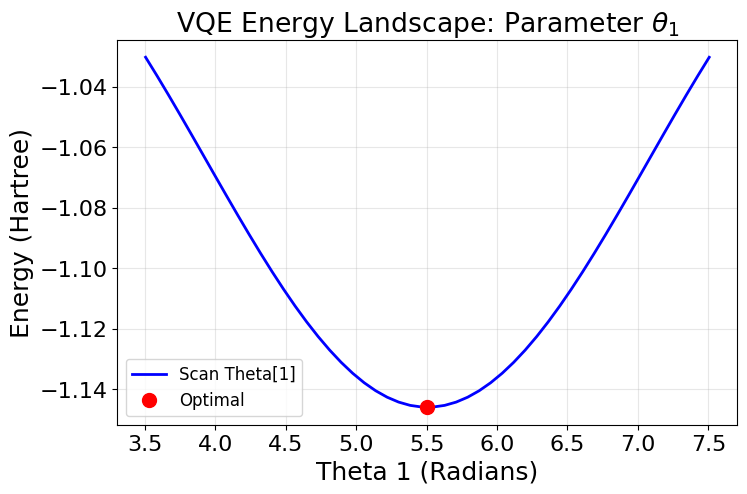

In [15]:

# --- 6b. Energy Landscape: Parameter Theta 1 ---
print("\n--- Scanning Energy Landscape for Theta 1 ---")

scan_idx = 1

theta_vals = np.linspace(best_params[scan_idx] - scan_range_width, 
                         best_params[scan_idx] + scan_range_width, 
                         scan_points)
energies = []

for val in theta_vals:
    current_params = best_params.copy()
    current_params[scan_idx] = val
    e = cost_func(current_params, ansatz, hamiltonian, estimator) + nuclear_repulsion
    energies.append(e)

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(8, 5))
plt.plot(theta_vals, energies, 'b-', linewidth=2, label=f'Scan Theta[{scan_idx}]')
plt.plot(best_params[scan_idx], optimized_energy, 'ro', markersize=10, label='Optimal')
plt.xlabel(f'Theta {scan_idx} (Radians)')
plt.ylabel('Energy (Hartree)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.title(f'VQE Energy Landscape: Parameter $\\theta_{scan_idx}$')
# plt.savefig(f"VQE-Energy-Theta{scan_idx}.pdf", bbox_inches="tight")
plt.show()




--- Scanning Energy Landscape for Theta 2 ---


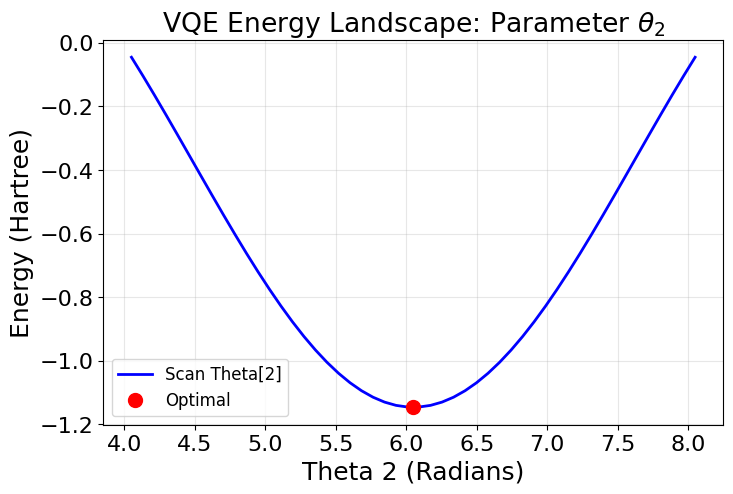

In [14]:

# --- 6c. Energy Landscape: Parameter Theta 2 ---
print("\n--- Scanning Energy Landscape for Theta 2 ---")

scan_idx = 2

theta_vals = np.linspace(best_params[scan_idx] - scan_range_width, 
                         best_params[scan_idx] + scan_range_width, 
                         scan_points)
energies = []

for val in theta_vals:
    current_params = best_params.copy()
    current_params[scan_idx] = val
    e = cost_func(current_params, ansatz, hamiltonian, estimator) + nuclear_repulsion
    energies.append(e)

plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

plt.figure(figsize=(8, 5))
plt.plot(theta_vals, energies, 'b-', linewidth=2, label=f'Scan Theta[{scan_idx}]')
plt.plot(best_params[scan_idx], optimized_energy, 'ro', markersize=10, label='Optimal')
plt.xlabel(f'Theta {scan_idx} (Radians)')
plt.ylabel('Energy (Hartree)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.title(f'VQE Energy Landscape: Parameter $\\theta_{scan_idx}$')
# plt.savefig(f"VQE-Energy-Theta{scan_idx}.pdf", bbox_inches="tight")
plt.show()

